In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report , ConfusionMatrixDisplay , confusion_matrix

In [2]:
# Define labels for classificcation
labels = ['non-vehicles', 'vehicles']

In [3]:
# Read image folder
directory ='./data'

In [4]:
# Create TRAINING dataset (80%)

train_set = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  image_size=(64,64),
  class_names = labels,
  seed=1,
  label_mode = 'categorical',
  batch_size=32)


Found 17760 files belonging to 2 classes.
Using 14208 files for training.


In [5]:
# Create VALIDATION dataset (20%)

val_set = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=1,
  class_names = labels,
  label_mode = 'categorical',
  image_size=(64,64),
  batch_size=32)


Found 17760 files belonging to 2 classes.
Using 3552 files for validation.


/var/folders/hq/hpdjlgpn3lb4tkwd5ckxz9cw0000gn/T/ipykernel_81005/2887092708.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,6,j+1)


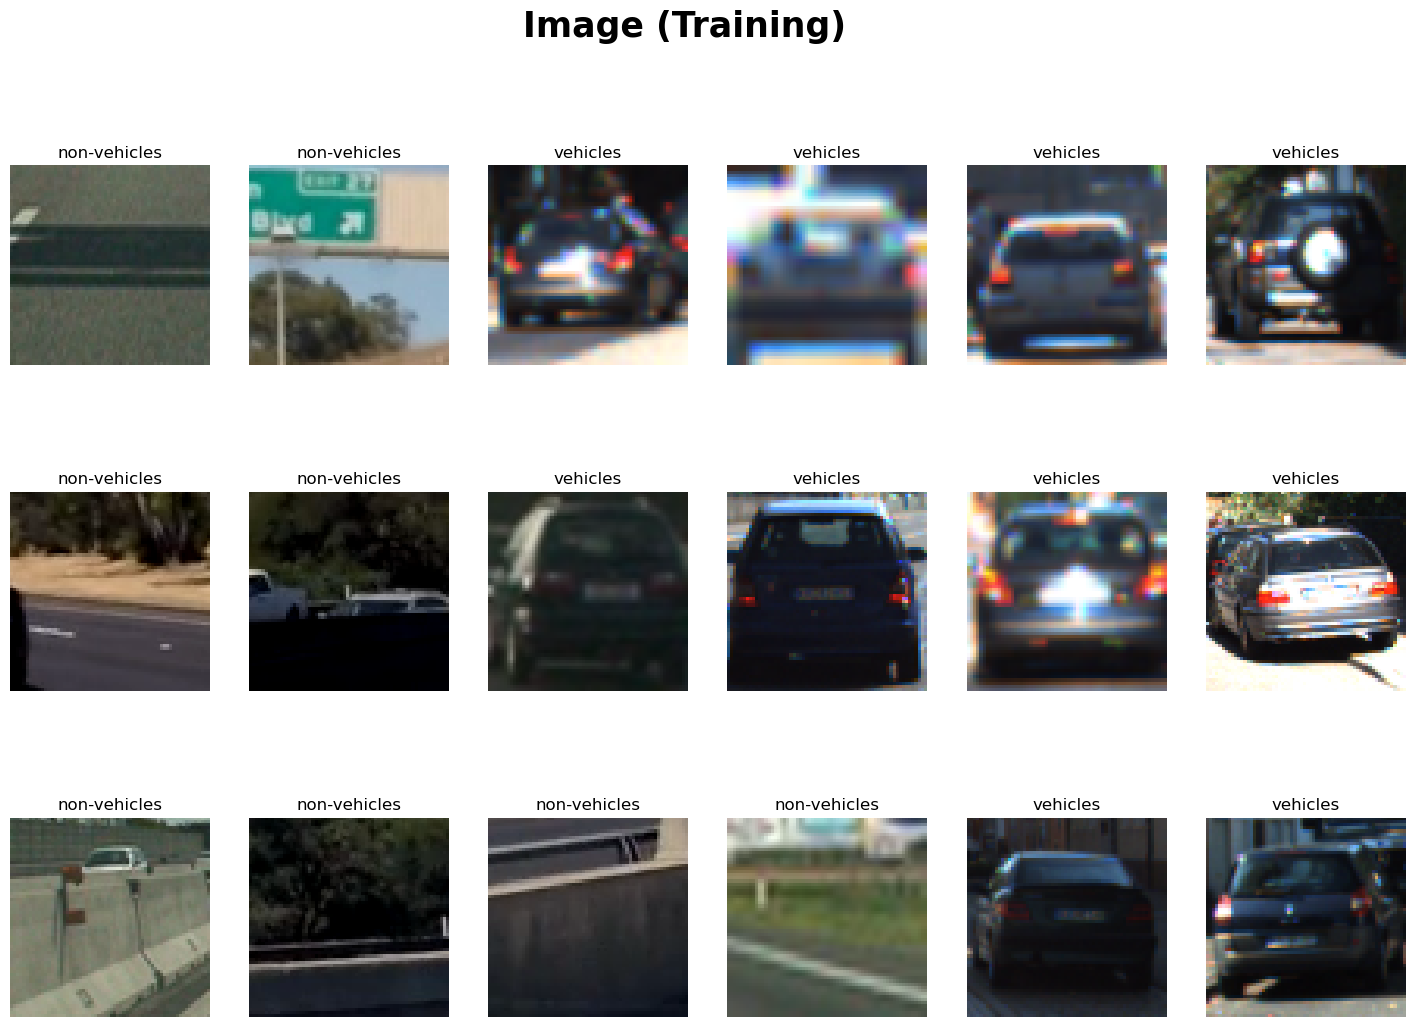

In [6]:
# Display image from Training dataset

n_images = 18
fig , axs = plt.subplots(figsize = (18,12))
fig.suptitle('Image (Training)', fontweight = 'bold' , fontsize = 25 , ha = 'center')
for img , label in train_set.take(1):
    for j in range(n_images):
        plt.subplot(3,6,j+1)
        plt.title(labels[np.argmax(label[j])])
        plt.imshow(img[j]/255.0)
        plt.axis('off')
    break
    

# Image Processing

In [7]:
# Split into TRAINING and TESTING (90-10)

import tensorflow as tf

DATASET_SIZE = len(list(train_set))
train_size = int(0.9 * DATASET_SIZE)
test_size = DATASET_SIZE - train_size
dataset = train_set.shuffle(buffer_size=DATASET_SIZE)

train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)

In [8]:
# check For splitting
print(f'Training = {train_set.cardinality().numpy()}\nValidation = {val_set.cardinality().numpy()}\nTesting = {test_set.cardinality().numpy()}')

Training = 399
Validation = 111
Testing = 45


In [9]:
# Rescaling
def rescaling(image , label):
    return image/63.0 , label

In [10]:
train_set = train_set.map(rescaling)
val_set = val_set.map(rescaling)
test_set = test_set.map(rescaling)

In [11]:
# Augmenting
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image , max_delta = 0.5)
    return image ,label

In [12]:
train_set = train_set.map(augment_data)

In [13]:
# Prefetching
train_set = train_set.prefetch(tf.data.AUTOTUNE)
val_set = val_set.prefetch(tf.data.AUTOTUNE)
test_set = test_set.prefetch(tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


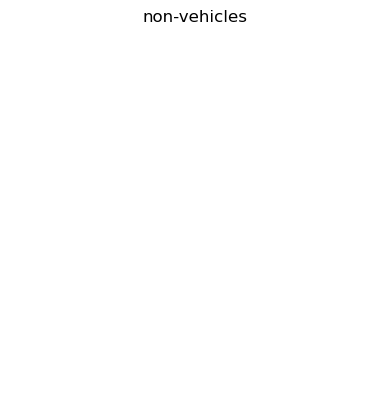

In [14]:
for img , label in test_set.take(3):
    plt.title(labels[np.argmax(label[10])])
    plt.imshow(img[10])
    plt.axis('off')
    break

# Modelling

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Create a simple CNN model
model = Sequential([
    # Convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Another convolutional layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the output of the convolutional layers
    Flatten(),
    
    # Dense (fully connected) layers
    Dense(128,activation='relu', kernel_regularizer=regularizers.l2(l=0.001), 
                          activity_regularizer=regularizers.l1(0.001),
                          bias_regularizer=regularizers.l1(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.001), 
                          activity_regularizer=regularizers.l1(0.001),
                          bias_regularizer=regularizers.l1(0.001)),
    Dropout(0.2),
    
    # Output layer
    Dense(2, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1

# Training

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,        
    verbose=1,
    restore_best_weights=True
)

history = model.fit(train_set , validation_data = val_set , epochs = 10, 
          steps_per_epoch=train_set.cardinality().numpy(),
          validation_steps=val_set.cardinality().numpy())

Epoch 1/10
399/399 [==============================] - 35s 83ms/step - loss: 0.6350 - accuracy: 0.8305 - val_loss: 0.4290 - val_accuracy: 0.9172
Epoch 2/10
399/399 [==============================] - 37s 89ms/step - loss: 0.3692 - accuracy: 0.9370 - val_loss: 0.3283 - val_accuracy: 0.9350
Epoch 3/10
399/399 [==============================] - 35s 86ms/step - loss: 0.2860 - accuracy: 0.9544 - val_loss: 0.2810 - val_accuracy: 0.9443
Epoch 4/10
399/399 [==============================] - 36s 86ms/step - loss: 0.2330 - accuracy: 0.9664 - val_loss: 0.1921 - val_accuracy: 0.9780
Epoch 5/10
399/399 [==============================] - 38s 92ms/step - loss: 0.1995 - accuracy: 0.9728 - val_loss: 0.1843 - val_accuracy: 0.9733
Epoch 6/10
399/399 [==============================] - 35s 84ms/step - loss: 0.1766 - accuracy: 0.9769 - val_loss: 0.2207 - val_accuracy: 0.9541
Epoch 7/10
399/399 [==============================] - 34s 80ms/step - loss: 0.1603 - accuracy: 0.9792 - val_loss: 0.1685 - val_accuracy:

# Evaluation

In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_set)
print('\nTest accuracy:', test_acc)

45/45 [==============================] - 2s 19ms/step - loss: 0.1129 - accuracy: 0.9854

Test accuracy: 0.9854166507720947


# Training history

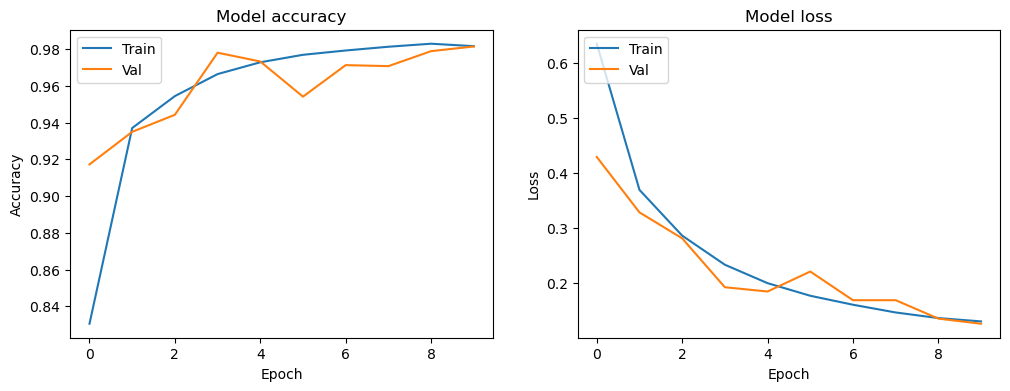

In [18]:
plt.figure(figsize=(12, 4))

# Plot training & validation ACCURACY values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation LOSS values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()


# Prediction

In [19]:
predictions = model.predict(test_set)

# Convert probabilities to class labels
pred_classes = np.argmax(predictions, axis=1)

45/45 [==============================] - 3s 19ms/step


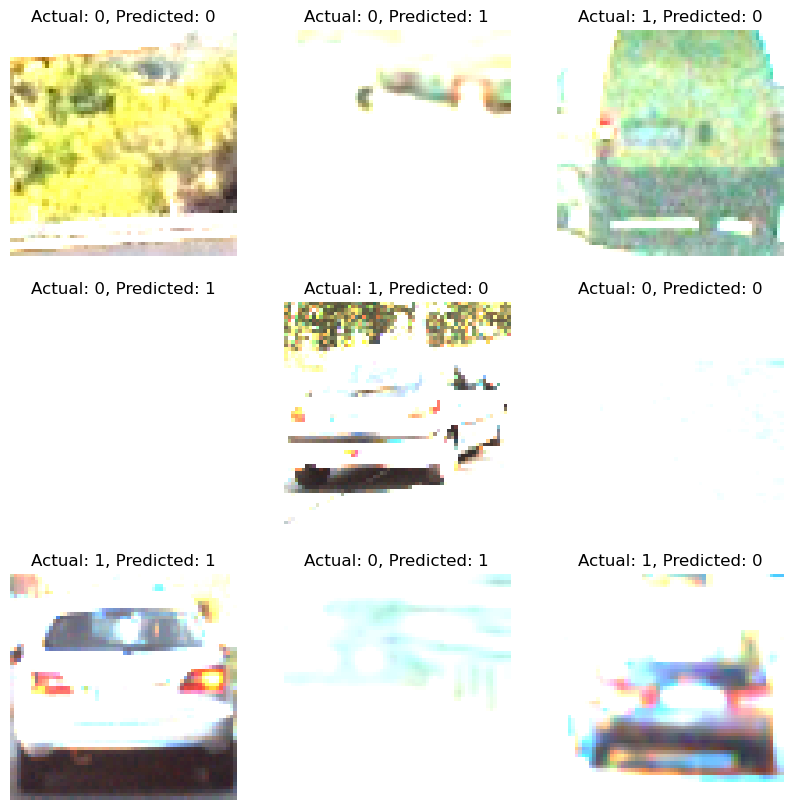

In [20]:
# Display prediction
plt.figure(figsize=(10, 10))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()

        # Check if the image is grayscale (single channel)
        if img.ndim == 2 or img.shape[2] == 1:
            #img = np.squeeze(img)  
            cmap = 'gray'
        else:
            cmap = None

        # Rescale if the image is normalized
        if img.max() <= 1.0: 
            img = (img * 255).astype("uint8")

        plt.imshow(img, cmap=cmap)
        plt.title(f"Actual: {np.argmax(labels[i])}, Predicted: {pred_classes[i]}")
        plt.axis("off")



In [21]:
# Generate actual labels from the test set
actual_labels = np.concatenate([y for x, y in test_set], axis=0)
actual_classes = np.argmax(actual_labels, axis=1)
labels = ['non-vehicles', 'vehicles']

# Classification report
print(classification_report(actual_classes, pred_classes, target_names=labels))


              precision    recall  f1-score   support

non-vehicles       0.47      0.49      0.48       678
    vehicles       0.53      0.50      0.51       762

    accuracy                           0.50      1440
   macro avg       0.50      0.50      0.50      1440
weighted avg       0.50      0.50      0.50      1440



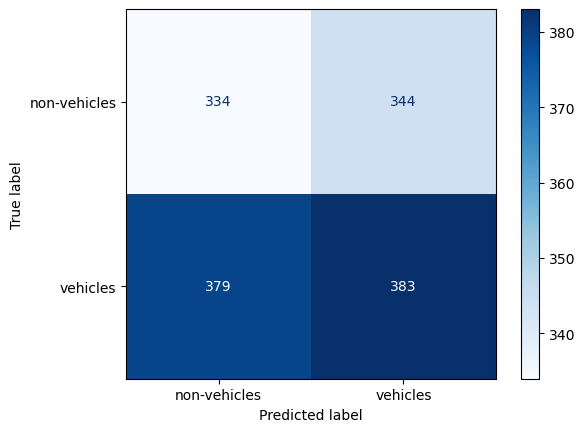

In [22]:
# Confusion Matrix
cm = confusion_matrix(actual_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)


disp.plot(cmap=plt.cm.Blues)
plt.show()

In [23]:
model.save('vehicle_classification_model.h5')


/Users/ngocle/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
